In [1]:
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import uproot
import os

timestamps = {}

for station in os.listdir('/cr/tempdata01/filip/iRODS/UubRandoms/converted/timestamps'):
    
    start, stop = np.inf, -np.inf
    for file in np.loadtxt(f"/cr/tempdata01/filip/iRODS/UubRandoms/converted/timestamps/{station}", usecols=[1, 2]):
        if file[0] < start: start = file[0]
        if file[1] > stop: stop = file[1]
    
    timestamps[station[:-4]] = (start, stop)

StationIDs = set({'NuriaJr' : 56, 'Peru' : 1737, 'Granada' : 1738, 'Jaco' : 1742, 'LeQuiDon' : 1744, 'RukaMalen' : -1, 'Svenja' : 1733}.values())
q_peak = {
    'Jaco' : np.array([189.4, 164.3, 158.6]),
    'Granada' : np.array([153.5, 160.6, 170]),
    'NuriaJr' : np.array([169.3, 176.9, 169.5]),
    'Svenja' : np.array([172.4, 187, 168.8]),
}

print(StationIDs)

{1733, 1737, 1738, 1742, 1744, 56, -1}


# Looking at Online Monitoring

In [2]:
t = [[], [], [], [], [], [], []]
r = [[], [], [], [], [], [], []]
VEMPeak = [[[], [], []], [[], [], []], [[], [], []], [[], [], []], [[], [], []], [[], [], []], [[], [], []]]


for day in [14, 15, 16, 17, 18]:

    file = uproot.open(f"/cr/tempdata01/filip/SSDCalib/Monit/mc_2022_11_{day}_00h00.root")

    for j, station in enumerate(StationIDs):
        points = np.argwhere(file["SDMonCal/SDMonCalBranch/fLsId"].array() == station)
        points = [i for l in points for i in l]

        vem = file["SDMonCal/SDMonCalBranch/fCalibration/fCalibration.fPeak[3]"].array()[points]
        rate = file["SDMonCal/SDMonCalBranch/fCalibration/fCalibration.fT1"].array()[points]
        
        for _ in rate: r[j].append(_)

        for i in range(3):
            for x in vem[:,i]:
                VEMPeak[j][i].append(x)

        t[j].append(file["SDMonCal/fTime"].array()[points])

for j in range(len(t)):
    t[j] = [i for l in t[j] for i in l]


NuriaJr: q_peak online = (160.5, 173.0, 159.8)
Peru: q_peak online = (153.7, 121.2, 152.4)
Granada: q_peak online = (152.9, 145.8, 157.9)
Jaco: q_peak online = (181.9, 154.7, 144.3)
LeQuiDon: q_peak online = (89.6, 88.4, 166.6)
Svenja: q_peak online = (141.3, 147.0, 146.5)


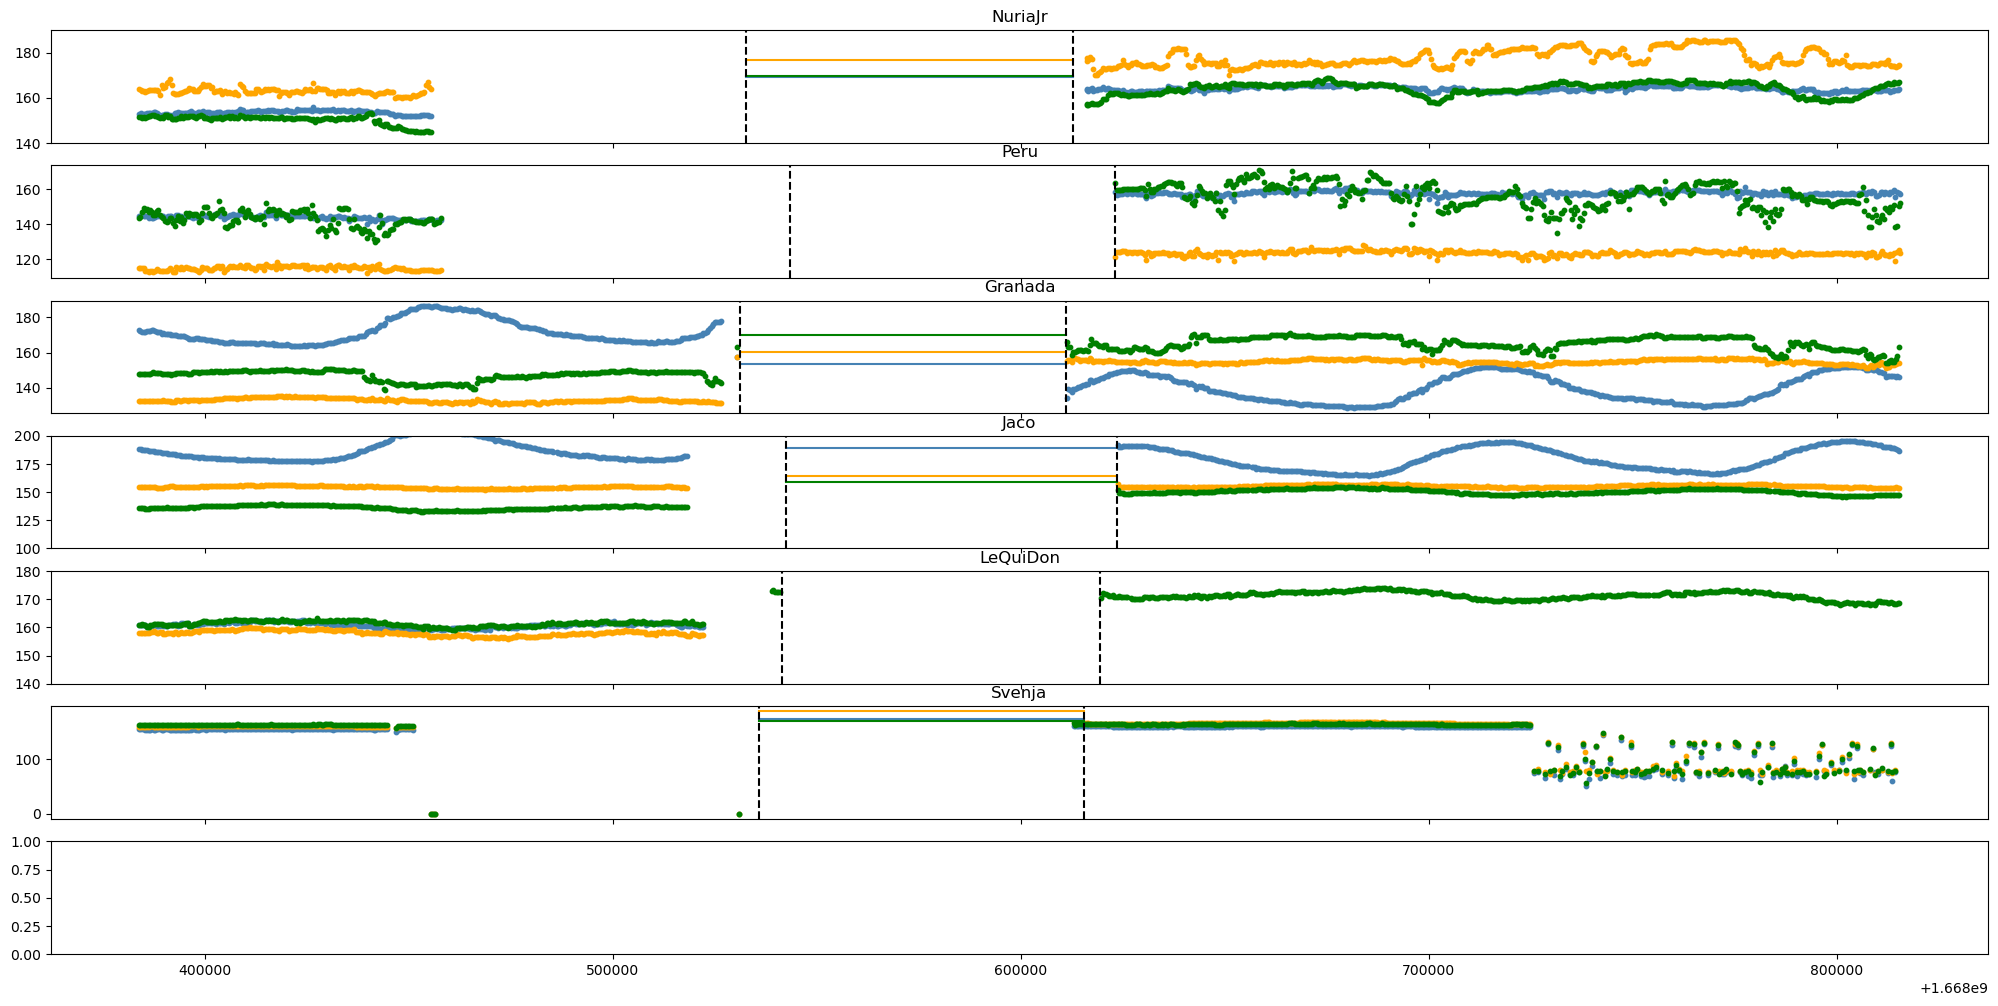

In [49]:
plt.rcParams["figure.figsize"] = [25,12]
fig, axes = plt.subplots(7,1, sharex = True)

for i, (peak, ax) in enumerate(zip(VEMPeak, axes)):
    if i == 0:
        ax.set_ylim(140, 190)
    elif i == 3:
        ax.set_ylim(100, 200)
    elif i == 4:
        ax.set_ylim(140, 180)
    # elif i == 5: 
    #     ax.set_ylim(150,190)
    #     ax.set_xlim(600000,700000)
    elif i == 6:
        continue

    station = ["NuriaJr", "Peru", "Granada", "Jaco", "LeQuiDon", "Svenja", 'RukaMalen'][i]
    ax.set_title(station)
    try:
        ax.plot(timestamps[station], [q_peak[station][0] for _ in range(2)], c = 'steelblue')
        ax.plot(timestamps[station], [q_peak[station][1] for _ in range(2)], c = 'orange')
        ax.plot(timestamps[station], [q_peak[station][2] for _ in range(2)], c = 'green')
    except KeyError: pass
    ax.scatter(t[i], peak[0], s = 10, c = 'steelblue')
    ax.scatter(t[i], peak[1], s = 10, c = 'orange')
    ax.scatter(t[i], peak[2], s = 10, c = 'green')
    ax.axvline(timestamps[station][0], c = "k", ls = '--')
    ax.axvline(timestamps[station][1], c = "k", ls = '--')

    print(f"{station}: q_peak online = ({np.mean(peak[0]):.1f}, {np.mean(peak[1]):.1f}, {np.mean(peak[2]):.1f})")



168
566 3


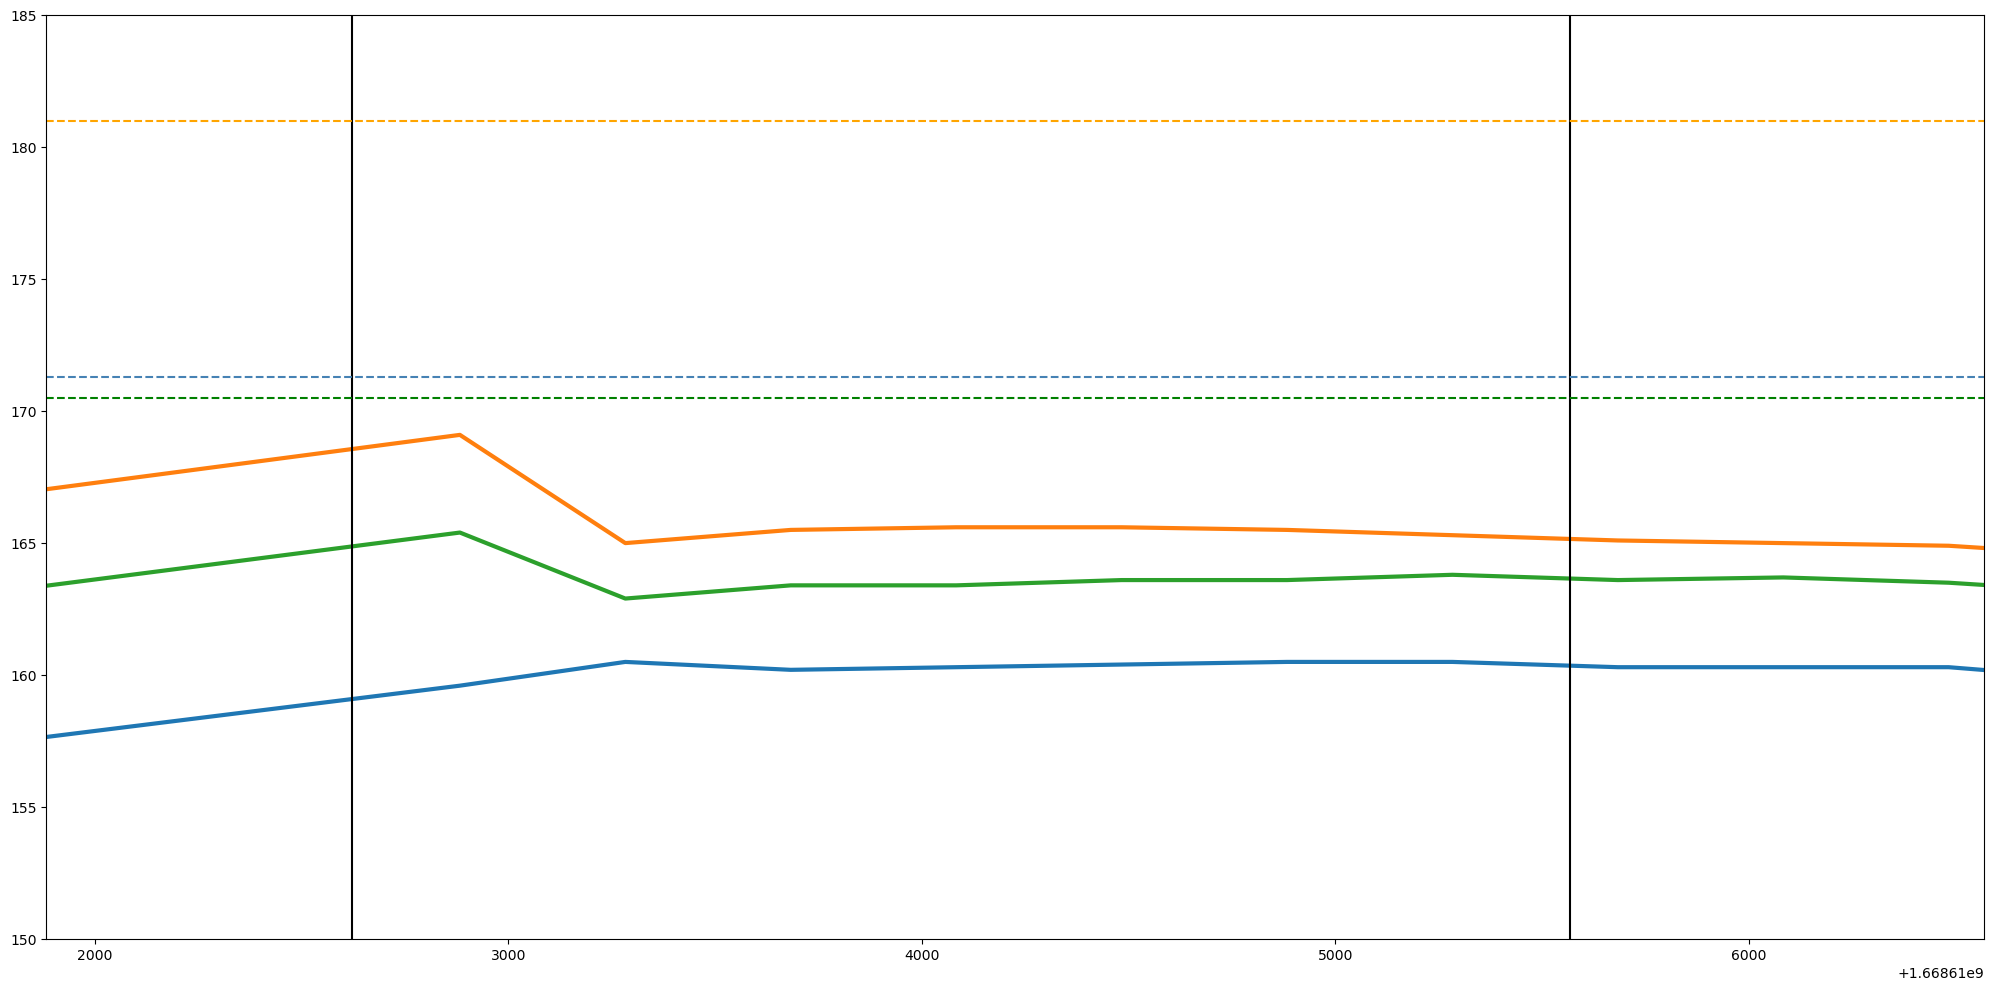

In [47]:
t_diff = np.argmax(np.diff([t[5]])[0]) + 1
print(t_diff)
print(len(t[5]), len(VEMPeak[5]))

plt.plot(t[5], VEMPeak[5][0], lw = 3)
plt.plot(t[5], VEMPeak[5][1], lw = 3)
plt.plot(t[5], VEMPeak[5][2], lw = 3)

plt.axvline(timestamps["Svenja"][1], c = 'k')
plt.axvline(1668612621, c = "k")
plt.ylim(150, 185)
plt.xlim(t[5][t_diff] - 1000, timestamps["Svenja"][1] + 1000)

plt.axhline(171.3, c = "steelblue", ls = '--')
plt.axhline(181, c = "orange", ls = '--')
plt.axhline(170.5, c = "green", ls = '--')

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
for i in range(len(r)):
    plt.scatter(t[i], np.array(r[i]) / 61 - 100, label = ["NuriaJr", "Peru", "Granada", "Jaco", "LeQuiDon", "Svenja", 'RukaMalen'][i])

plt.legend()

# Looking at the production data (= recostructed events)

In [ ]:
# Find out if tanks in question participated in any events
for day in [14, 15, 16, 17]:
    file = uproot.open(f"/cr/tempdata01/filip/iRODS/MonitoringData/SD_2022_11_{day}_adst.root")
    for i, event in enumerate(file["recData/event./event.fSDEvent/event.fSDEvent.fStations/event.fSDEvent.fStations.fId"].array()):
        if set(event).intersection(StationIDs): print(event)

In [ ]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = [40, 20]

for i, (station, (start, stop)) in enumerate(timestamps.items()):
    plt.axvline(dt.datetime.fromtimestamp(start), ls = '--', lw = 0.8, color = cycle[i], label=station)
    plt.axvline(dt.datetime.fromtimestamp(stop), ls = '--', lw = 0.8, color = cycle[i])

    print(len(t), len(VEMPeak[i][0]))

    plt.plot(t[i], VEMPeak[i][0], ls="solid", color = cycle[i])
    plt.plot(t[i], VEMPeak[i][1], ls="dashed", color = cycle[i])
    plt.plot(t[i], VEMPeak[i][2], ls="dotted", color = cycle[i])

print("Start:", dt.datetime.fromtimestamp(min([i[0] for i in timestamps.values()])))
print("Stop :", dt.datetime.fromtimestamp(max([i[1] for i in timestamps.values()])))

#_ = plt.xlim(dt.datetime.fromtimestamp(min([i[0] for i in timestamps.values()]) - 3600), dt.datetime.fromtimestamp(max([i[1] for i in timestamps.values()]) + 3600))

plt.legend()

# Looking at all T3s, maybe something is appearing there?

In [ ]:
# Find out if tanks in question participated in any events
for day in [15, 16]:
    file = uproot.open(f"/cr/tempdata01/filip/iRODS/MonitoringData/ad_2022_11_{day}_12h00.root")

    for item in file.keys():
        if 'Sd-only' in item:
            print(item.__dir__())

            break
    
    #for key, val in file.items():
    #    print(val)

    #for i, event in enumerate(file["recData/event./event.fSDEvent/event.fSDEvent.fStations/event.fSDEvent.fStations.fId"].array()):
    #   if set(event).intersection(StationIDs): print(event)

    break